Cat labels = 97, Dog labels = 101. <- Indicates mislabeling, supposed to be 99 of each!


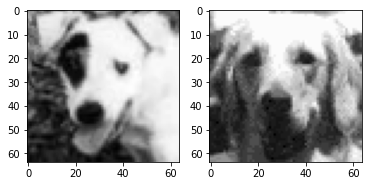

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

catsndogs = pd.read_csv('data\CATSnDOGS.csv')
labels = pd.read_csv('data\Labels.csv')


cat_ids = np.nonzero(labels.values[:,0]==0)[0] #[0] to get into tuple
dog_ids = np.nonzero(labels.values[:,0]==1)[0]

print(f'Cat labels = {len(cat_ids)}, Dog labels = {len(dog_ids)}. <- Indicates mislabeling, supposed to be 99 of each!')

catid = np.random.choice(cat_ids)
dogid = np.random.choice(dog_ids)

cat = catsndogs.iloc[catid].to_numpy().reshape((64,64), order='F')
dog = catsndogs.iloc[dogid].to_numpy().reshape((64,64), order='F')

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cat, cmap='gray')
axs[1].imshow(dog, cmap='gray')
plt.show()


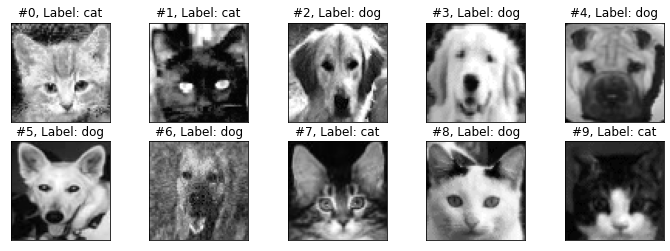

In [2]:
names = ['cat', 'dog']

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))

for i, axr in enumerate(axs):
    for j, ax in enumerate(axr):
        ax.imshow(catsndogs.iloc[i*len(axr)+j].to_numpy().reshape((64,64), order='F'), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(f'#{i*len(axr)+j}, Label: {names[labels.values[i*len(axr)+j,0]]}')

# Question 1 (60p)



## 1a (10p)
 - Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? Compare at least 3 classifiers.

 - Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? Why do you think these are difficult images to classify? Do the classifiers struggle with the same observations?

 - Are the errors balanced or is one class more difficult to classify correctly?

In [3]:
# First we try to classify, using 3 classifiers
# Maybe Linear regression, QDA(?), and kNN?

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


x = catsndogs.to_numpy()
y = labels.values[:,0]
accuracy = {
    'knn': 0,
    'lr': 0,
    'rf': 0
}

mislabeled = {
    'knn': [],
    'lr': [],
    'rf': []
}
repetitions = 20


for i in range(repetitions):
    x_train, x_test, y_train, y_test = train_test_split(catsndogs, labels, test_size=0.2)

    # kNN
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(x_train, y_train.values[:,0])
    y_pred = knn.predict(x_test)
    accuracy['knn'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['knn'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

    # Linear regression
    lr = LogisticRegression(max_iter=500)
    lr.fit(x_train, y_train.values[:,0])
    y_pred = lr.predict(x_test)
    accuracy['lr'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['lr'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

    # Random forest
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train.values[:,0])
    y_pred = rf.predict(x_test)
    accuracy['rf'] += np.sum(y_pred==y_test.values[:,0])/len(y_test) /repetitions
    mislabeled['rf'].extend(y_test.index[(y_pred!=y_test.values[:,0])].to_list())

#print(accuracy)
#print(mislabeled)


Fraction of dogs in the set of images mislabeled more than 2 times by one or more model:
0.7272727272727273


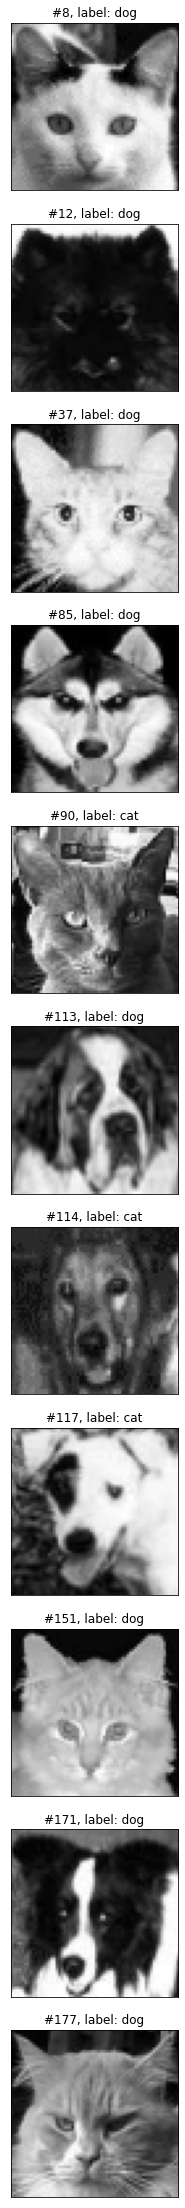

In [4]:
occurences = {}
threshold = 2   # More than this to occur "often"
combined = np.array([])

for key in mislabeled.keys():
    occurences[key] = np.bincount(mislabeled[key])
    tmp = np.array(mislabeled[key])
    combined = np.append(combined, np.unique(tmp[occurences[key][tmp]>threshold])).astype(int)

#print(np.bincount(combined))
#print(combined)

consistent_mislabels = np.argwhere(np.bincount(combined)>2).flatten()

# Visualize mislabeled images
fig, axs = plt.subplots(nrows=len(consistent_mislabels), ncols=1, figsize=(8,40))
for i, label in enumerate(consistent_mislabels):
    axs[i].imshow(catsndogs.iloc[label].to_numpy().reshape((64,64), order='F'), cmap='gray')
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
    axs[i].set_title(f'#{label}, label: {names[labels.values[label,0]]}')

# Are the errors balanced?
print(f'Fraction of dogs in the set of images mislabeled more than {threshold} times by one or more model:\n{np.sum(labels.values[consistent_mislabels,0])/len(labels.values[consistent_mislabels,0])}')

In [5]:
len(consistent_mislabels)

11

For kNN with k=5 we get 0.75, logistic regression we get 0.74, and random forest gives 0.71. This is better than random, but not particularly good.

Some images are quite consistently mislabeled. If we consider being mislabeled by all three classifiers more than twice out of 20 repetitions consistent, there are about 18 consistently mislabeled images. (9/18 mislabeled images, some dogs that have cat-like ears) However, despite 80/20 train/test split no images seem to be close to being mislabeled near 80% of the time, the most is around 20-50%     --(???)--

The errors are imbalanced, out of the consistently mislabeled images about 80% were labeled as "dog", although some where mislabeled. 

## 1b (10p)
 - Identify the most important pixels for classification - are these easy to identify or is there uncertainty in the selection of important features? Compare at least 3 methods for selecting/identifying features. Note, does not need to be the same methods as in 1a. Can you think of a way to improve on the stability of selection/identification?

 - Can you explain why these pixels are selected/are deemed important?

 - Do the identified predictive features differ between the classification methods?

In [13]:
# Logisticregression CV
# Train model on full dataset - get coef to make correct model

x = catsndogs.to_numpy()
y = labels.values[:,0]

lrCV = LogisticRegressionCV(Cs=np.logspace(-4, 4, 30), multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000, scoring='accuracy').fit(x, y)

#lrCV = LogisticRegressionCV(Cs=hp, cv=n_folds, scoring='f1', penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(x, y)

#print(lrCV.C_)


[1.3738238]


bootstrap 0
[0.00096287 0.0005641  0.         ... 0.         0.         0.        ]
[0.00056129 0.         0.         ... 0.00063801 0.         0.        ]
[0.00019881 0.00036898 0.         ... 0.         0.         0.        ]
[0.         0.         0.         ... 0.         0.00019426 0.        ]
[0.00073337 0.         0.         ... 0.         0.         0.00202868]


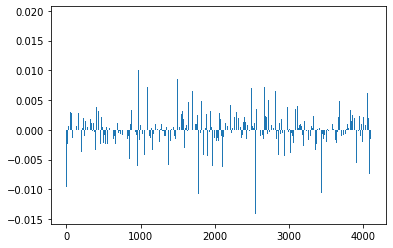

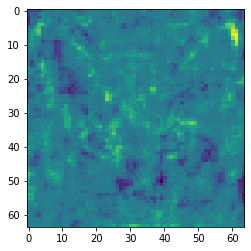

In [36]:
repetitions = 5

lr = LogisticRegression(C=lrCV.C_[0], multi_class='ovr', solver='liblinear', penalty='l1', intercept_scaling=1000)
lr_coefs = np.zeros(len(x[0]))

rf = RandomForestClassifier()
rf_coefs = np.zeros(len(x[0]))



for i in range(repetitions):
    if i % 50 == 0:
        print(f'bootstrap {i}')
    # Choose n random points
    idxs = np.random.choice(len(y), size=len(y), replace=True)
    x_tmp = x[idxs]
    y_tmp = y[idxs]

    # Fit model to points
    lr.fit(x_tmp, y_tmp)
    rf.fit(x_tmp, y_tmp)

    # Get coefficients to see most important features
    lr_coefs += lr.coef_[0]
    rf_coefs += rf.feature_importances_

fig, axs = plt.subplots(nrows=1, ncols=3)
lr_importance = lr_coefs.reshape((64,64), order='F')
lr_coefs /= len(x[0])   # Ska man göra detta eller ej?

axs[0].imshow(lr_importance)
axs[0].set_title("Pixel's coefficient in Logistic decision function")
#TODO continue plotting 3 pixel importance 

rf_importance = rf_coefs.reshape((64,64), order='F')
axs[1].imshow(rf_importance)

sorted_ids = np.argsort(-np.abs(lr_coefs))
lr_coefs[sorted_ids]
plt.show()